In [1]:
import os
import sys
sys.path.append(os.path.join('..', 'src'))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from genes_annotations import *
from autoencoder import *
from utils import *
import shap

## Summary 

1. [Construire le masque et sélectionner les données](#Construire-le-masque-et-sélectionner-les-données)

2. [Loading the model...](#Loading-the-model...)

3. [Calcul des shapley values à partir des gènes](#Calcul-des-shapley-values-à-partir-des-gènes)

4. [Lecture des shapley values enregistrées et plot](#Lecture-des-shapley-values-enregistrées-et-plot)

5. [Calcul des shapley values à partir des go terms](#Calcul-des-shapley-values-à-partir-des-go-terms)

6. [VIANN force plot](#VIANN-force-plot)

## Construire le masque et sélectionner les données

In [19]:
filename = "../data_tisch2/Glioma_GSE102130_expression.h5"

h5 = read_h5(filename)

In [20]:
selected_genes = get_all_genes(h5)

In [21]:
goterm, genes_go, all_go, all_genes = get_all_gene_annotations(h5, levels=[4], kinds=['biological_process'])

HMS:0:00:08.238023 606,840 annotations READ: ../goa_human.gaf 
../go.obo: fmt(1.2) rel(2021-02-01) 50,515 GO Terms; optional_attrs(consider replaced_by)


In [5]:
mask = build_mask(h5,genes_go,all_go,all_genes)

In [6]:
expr_mat = build_expr_mat(h5)
expr_mat = select_gene_expr_v2(h5, expr_mat, all_genes)
std_expr_mat = min_max_normalisation(std_normalisation(expr_mat))

'build_expr_mat'  507.97 ms
'select_gene_expr_v2'  392.05 ms


In [7]:
table = pd.read_csv('../data_tisch2/Glioma_GSE102130_CellMetainfo_table.tsv', delimiter='\t')
targets = np.array(table['Cluster'])

## Loading the model...

In [14]:
clf_pipeline(mask, std_expr_mat, targets, all_genes, all_go, n_epochs=100, batch_size=50, print_loss=100, output_file='model.pth', embed_file='embeddings_clf.csv')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              Tanh-1              [-1, 1, 1901]               0
      MaskedLinear-2              [-1, 1, 1901]               0
            Linear-3               [-1, 1, 100]         190,200
              Tanh-4               [-1, 1, 100]               0
            Linear-5                [-1, 1, 15]           1,515
           Softmax-6                [-1, 1, 15]               0
Total params: 191,715
Trainable params: 191,715
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.03
Params size (MB): 0.73
Estimated Total Size (MB): 0.80
----------------------------------------------------------------
[1,    65] loss: 2.63378, accuracy: 0.47535
[2,    65] loss: 2.42673, accuracy: 0.65311
[3,    65] loss: 2.26937, accuracy: 0.75662
[4,    65] loss: 2.16632, accuracy: 0.

(GeneClassifier(
   (encoder): Sequential(
     (0): MaskedLinear(
       (activation): Tanh()
     )
     (1): Linear(in_features=1901, out_features=100, bias=True)
     (2): Tanh()
   )
   (clf): Sequential(
     (0): Linear(in_features=100, out_features=15, bias=True)
     (1): Softmax(dim=1)
   )
 ),
 array([[-0.9902122 , -0.73101681,  0.86329859, ..., -0.27101707,
          0.59257483, -0.83068925],
        [ 0.99927139, -0.95405024,  0.83639091, ...,  0.87095261,
          0.9812628 , -0.90574759],
        [ 0.87508076,  0.46045208, -0.26853603, ..., -0.05704583,
         -0.23177932, -0.90609151],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]))

In [15]:
dataset, loader = get_train_loader(std_expr_mat, targets)

In [2]:
model = torch.load('model.pth')

## Calcul des shapley values à partir des gènes

In [10]:
batch = next(iter(loader))
seq, _ = batch

N_bg = 20
N_test = 300

seq = torch.Tensor(std_expr_mat)

ind_bg = torch.randperm(len(seq))[:N_bg]
ind_test = torch.randperm(len(seq))[:N_test]

background = seq[ind_bg]
test = seq[ind_test]

#background = torch.Tensor(std_expr_mat[:20,:])
#test = torch.Tensor(std_expr_mat[20:1000,:])

In [11]:
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [ ]:
for i in range(len(shap_values)):
    np.savetxt('../shapley/'+str(i)+'.txt', shap_values[i])

## Lecture des shapley values enregistrées et plot

In [3]:
shap_values  = [np.genfromtxt('../shap_genes/'+str(i)+".txt") for i in range(15)]

In [12]:
n_genes = shap_values[0].shape[0]

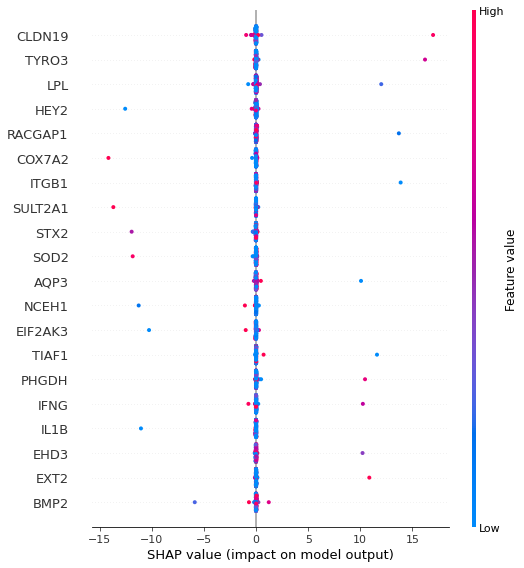

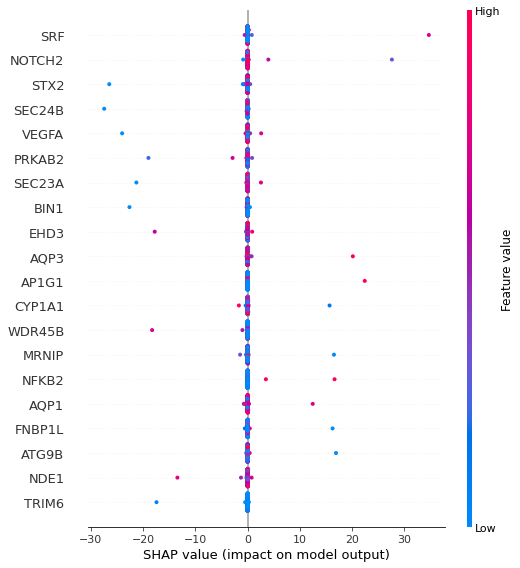

In [14]:
for i in range(15):
    shap.summary_plot(shap_values[0], features=test, feature_names=all_genes)
    shap.summary_plot(shap_values[1], features=test, feature_names=all_genes)

In [ ]:
shap.force_plot(e.expected_value[0], shap_values[0], features=test, feature_names=all_genes)

In [20]:
e.expected_value

array([2.1376829e-01, 4.2543131e-01, 1.4504869e-01, 6.9587370e-03,
       1.6229222e-02, 5.2526966e-04, 4.4753896e-03, 3.8515877e-02,
       2.4149169e-03, 2.4514982e-02, 1.1859284e-01, 3.5916141e-04,
       1.0433820e-04, 2.2576432e-04, 2.8352225e-03], dtype=float32)

## Calcul des shapley values à partir des go terms

In [17]:
data_tensor = torch.Tensor(std_expr_mat)

In [18]:
data_go_terms = model.encoder[0](data_tensor)

In [19]:
data_go_terms.shape

torch.Size([4058, 1901])

In [20]:
partial = PartialClassifier(model)

In [21]:
partial(data_go_terms)

tensor([[9.9784e-01, 2.5728e-04, 1.4991e-04,  ..., 1.5232e-05, 1.2064e-06,
         6.3303e-06],
        [9.8913e-01, 1.3407e-03, 1.5847e-03,  ..., 7.6013e-04, 4.5084e-06,
         6.2023e-05],
        [9.9545e-01, 1.7712e-03, 5.2141e-04,  ..., 1.4271e-05, 4.5585e-06,
         5.0986e-06],
        ...,
        [9.2303e-01, 2.0570e-02, 1.0133e-02,  ..., 2.4874e-05, 1.6418e-05,
         2.0956e-05],
        [8.3139e-01, 2.9076e-02, 1.3248e-02,  ..., 3.4303e-05, 1.8566e-05,
         4.4745e-05],
        [9.0689e-01, 1.4337e-02, 1.1708e-02,  ..., 2.7946e-05, 1.3928e-05,
         3.6802e-05]], grad_fn=<SoftmaxBackward>)

In [22]:
N_bg = 400
N_test = 800

seq = torch.Tensor(data_go_terms)

ind_bg = torch.randperm(len(seq))[:N_bg]
ind_test = torch.randperm(len(seq))[:N_test]

background_go = seq[ind_bg]
test_go = seq[ind_test]


In [23]:
e = shap.DeepExplainer(partial, background_go)
shap_values = e.shap_values(test_go)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [24]:
shap_values[0].shape

(800, 1901)

In [25]:
test_go.shape

torch.Size([800, 1901])

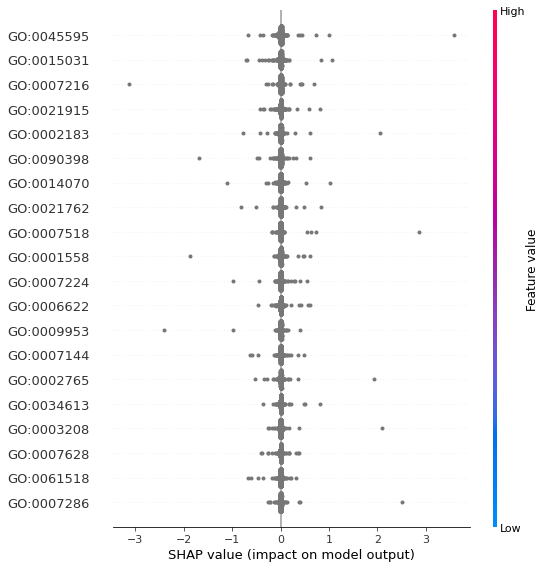

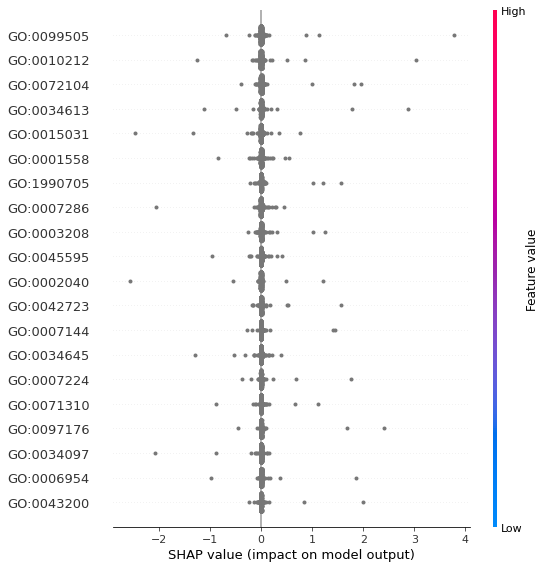

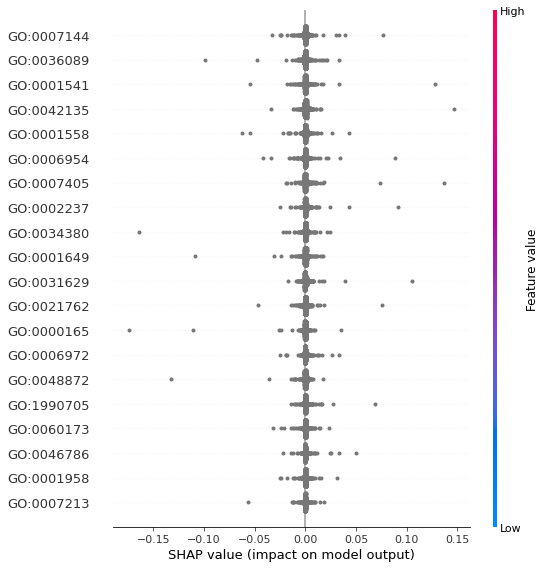

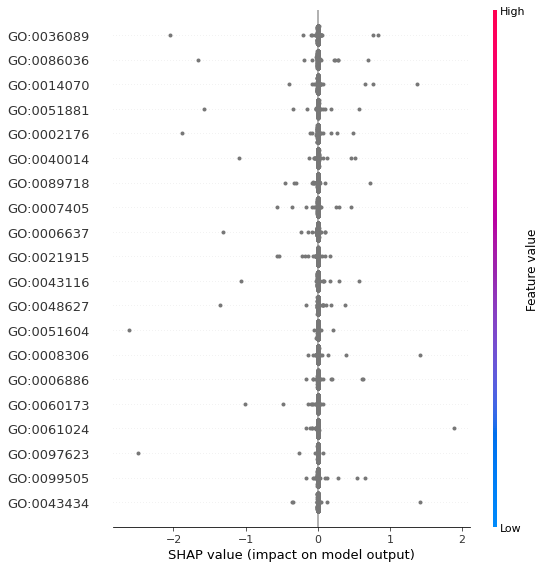

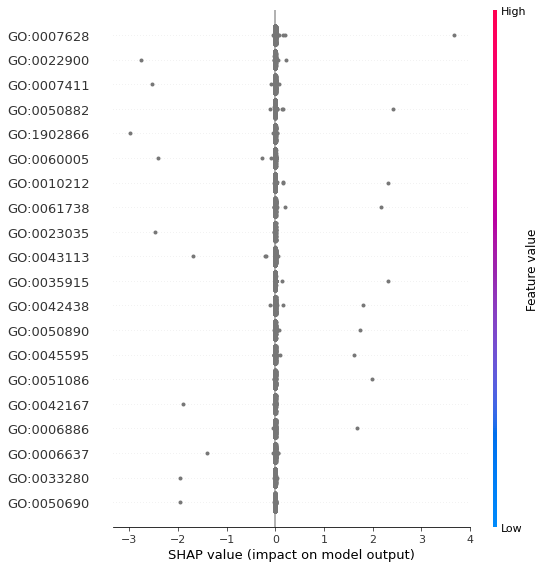

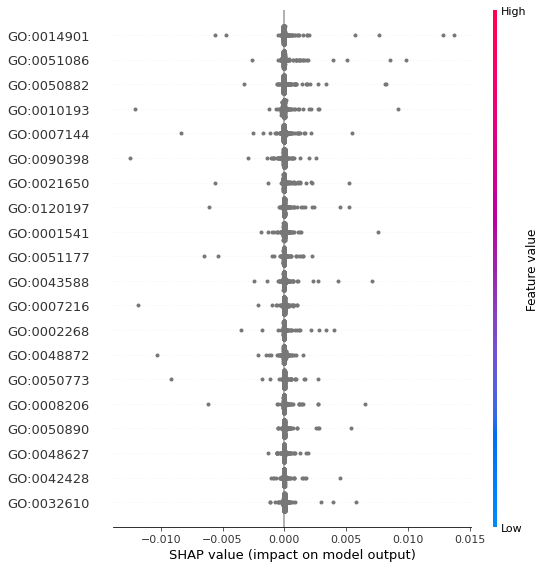

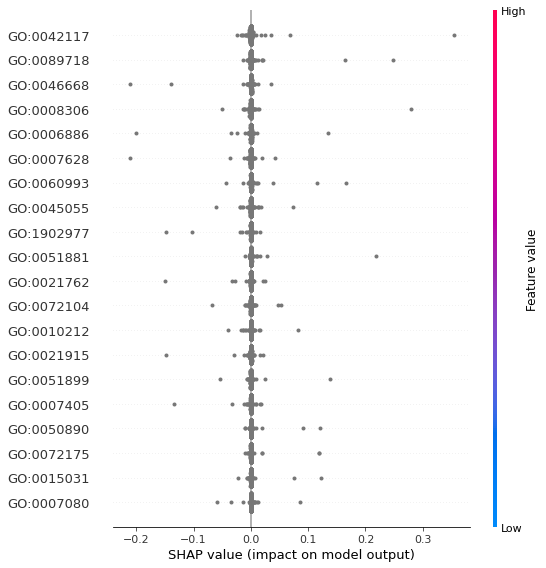

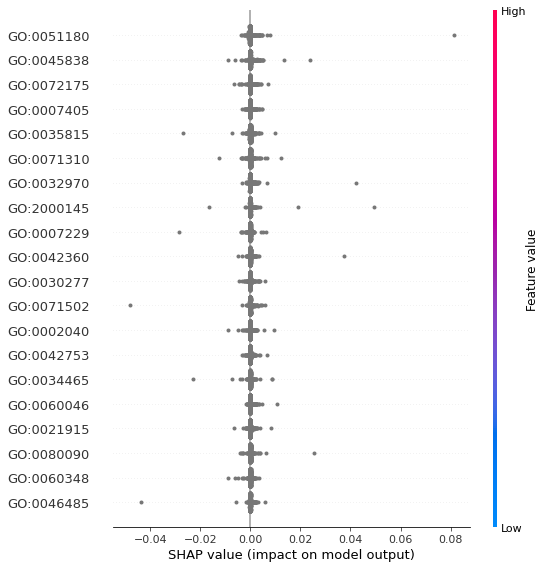

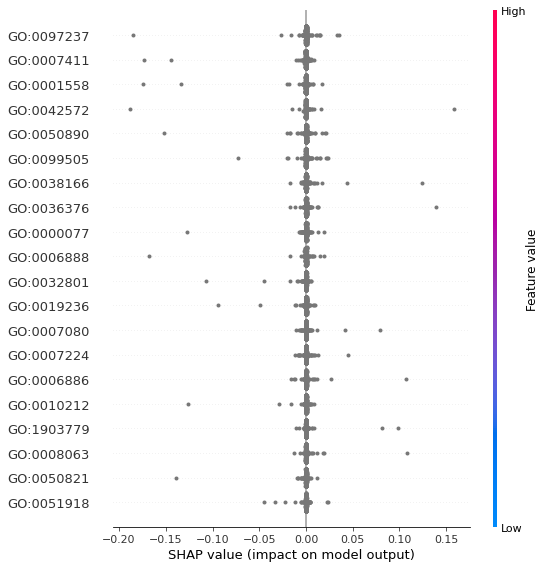

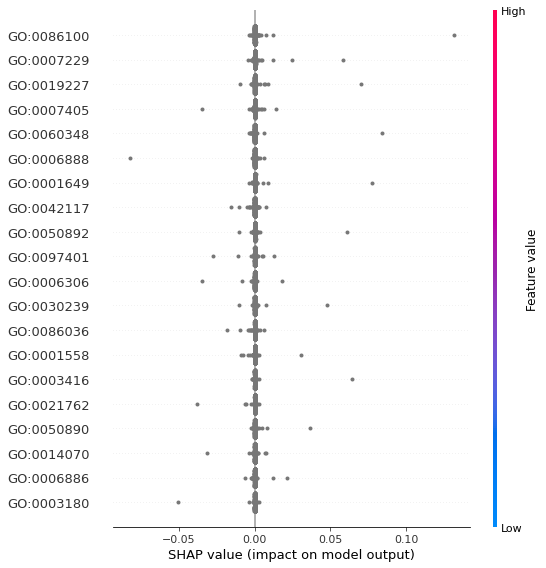

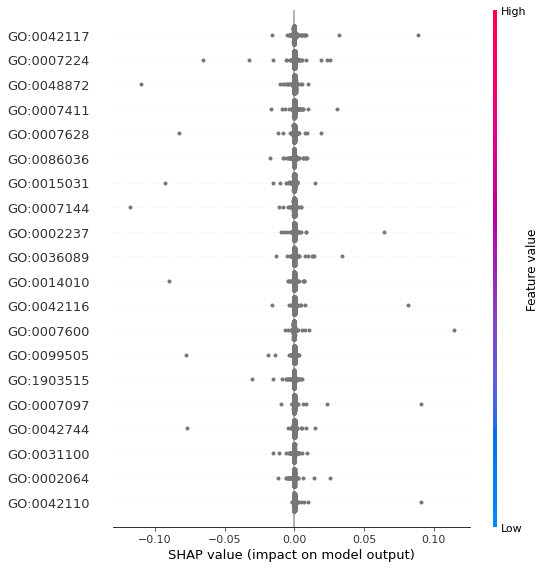

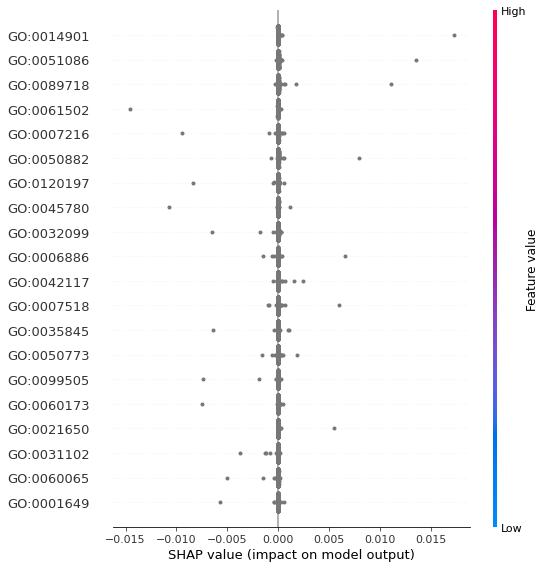

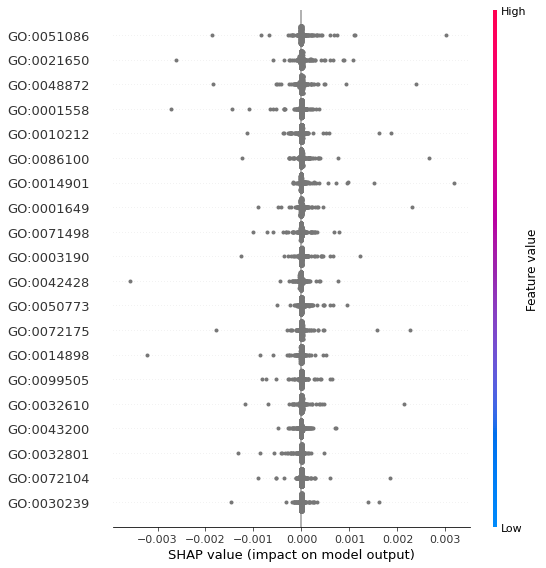

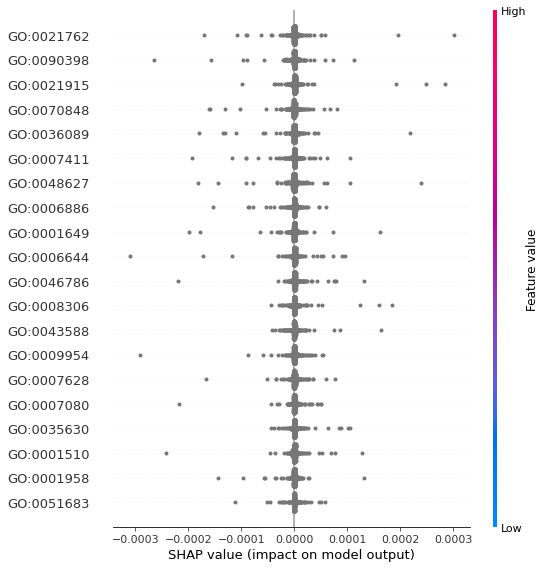

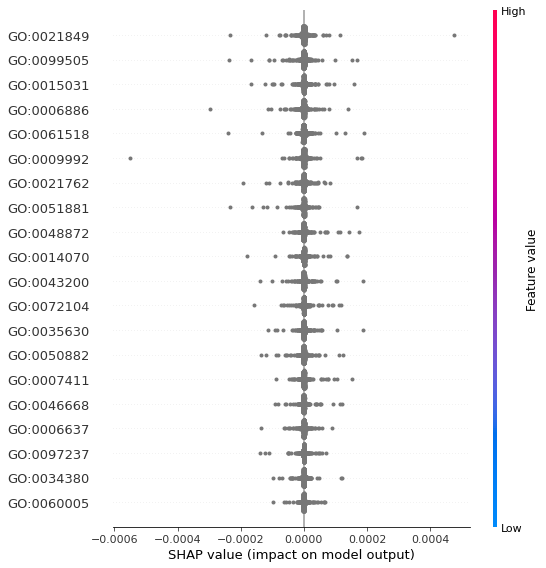

In [26]:
for i in range(15):
    shap.summary_plot(shap_values[i], features=test_go, feature_names=all_go)

In [27]:
len(all_go)

1901

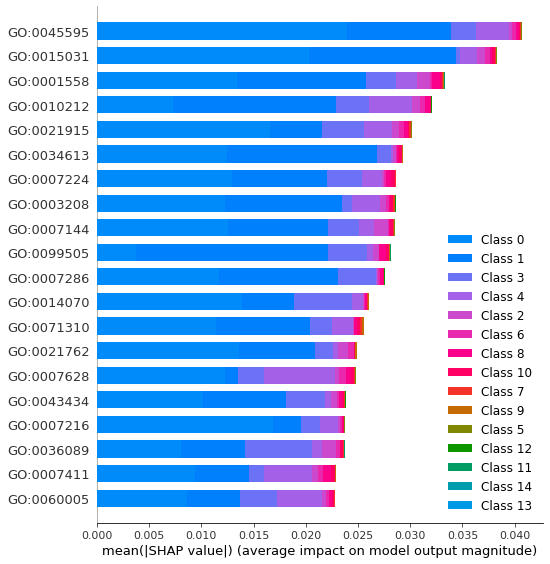

In [29]:
shap.summary_plot(shap_values, features=test_go, feature_names=all_go)

In [58]:
shap.summary_plot

<function shap.plots._beeswarm.summary_legacy(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7feb37da7390>, auto_size_plot=None, use_log_scale=False)>

In [3]:
model

GeneClassifier(
  (encoder): Sequential(
    (0): MaskedLinear(
      (activation): Tanh()
    )
    (1): Linear(in_features=1901, out_features=100, bias=True)
    (2): Tanh()
  )
  (clf): Sequential(
    (0): Linear(in_features=100, out_features=15, bias=True)
    (1): Softmax(dim=1)
  )
)

## VIANN force plot 

In [4]:
viann = model.encoder[0].get_VIANN()

In [5]:
viann

tensor([1.9418e-05, 3.4895e-05, 5.1583e-04,  ..., 4.2865e-04, 5.5957e-04,
        6.6389e-05])

In [22]:
n_elements_indices = list(viann.argsort(descending=True)[:15].numpy())

In [29]:
best_genes = [all_genes[i] for i in n_elements_indices]

In [26]:
len(all_go)

1901

In [27]:
n_elements_indices

[2953,
 7970,
 2063,
 2608,
 2599,
 507,
 2466,
 2865,
 7966,
 3768,
 3080,
 7663,
 332,
 6460,
 8155]

In [17]:
performance=viann[n_elements_indices].numpy()

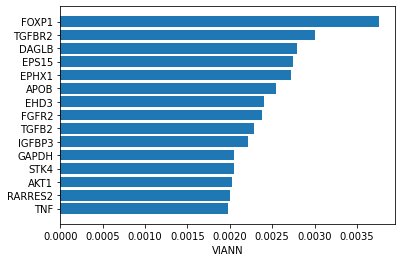

In [34]:
fig, ax = plt.subplots()
y_pos = np.arange(len(n_elements_indices))
ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(best_genes)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('VIANN')
plt.show()
fig.savefig('VIANN.svg')